<a href="https://colab.research.google.com/github/nahumsa/Segmentation/blob/master/CT%20Scans%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CT Scan Segmentation

In this example we will apply a UNET with Xception backbone for segmenting CT scans for three kind of artifacts: ground class opacification, consolidations and pleural effusions.

This is really important because we can use this to help the Physicians who need a fast result during the COVID19 epidemic.

# 1) Data

For this example we will need to upload the data retrieved on the [MedSeg website](http://medicalsegmentation.com/covid19/) and upload to the google drive or local computer. 

## 1.1) Getting the data from google drive

Here I chose to upload to drive, to train on the Google Colab.

In [0]:
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/drive/')
%cd '/content/drive/My Drive/MedSeg'
clear_output(wait=True)
print("Mounting Complete!")

Mounting Complete!


The data that we are using is on NIFTI, therefore we need to use [nibabel](https://nipy.org/nibabel/) for reading this kind of data.

We will unpack to a np.array using `.get_fdata()`.

In [0]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img_train = os.path.join('tr_im.nii.gz')
img_train = nib.load(img_train)

mask_train = os.path.join('tr_mask.nii.gz')
mask_train = nib.load(mask_train) 

img_val = os.path.join('val_im.nii.gz')
img_val = nib.load(img_val)

img_train = img_train.get_fdata() 
mask_train = mask_train.get_fdata()
img_val = img_val.get_fdata()

## 1.2) Exploratory Data Analysis (EDA)

Now let's check how the images are distributed and if they are normalized.

In [0]:
print(f'The shape of our train dataset is: {img_train.shape}')
print(f'The shape of our mask dataset is: {mask_train.shape}')
print(f'The shape of our validation dataset is: {img_val.shape}')

The shape of our train dataset is: (512, 512, 100)
The shape of our mask dataset is: (512, 512, 100)
The shape of our validation dataset is: (512, 512, 10)


We see that we have 100 training images and 10 validation images.

We will reshape our numpy array to index the image on the first value and not in the last value.

We will also add an dimension because it is needed for the Conv2D layer.

In [0]:
# Reshaping
img_train = img_train.T
mask_train = mask_train.T
img_val = img_val.T

#Adding a dimension
img_train = np.expand_dims(img_train, -1)
mask_train = np.expand_dims(mask_train, -1)
img_val = np.expand_dims(img_val, -1)

print(f'The shape of our train dataset is: {img_train.shape}')
print(f'The shape of our mask dataset is: {mask_train.shape}')
print(f'The shape of our validation dataset is: {img_val.shape}')

The shape of our train dataset is: (100, 512, 512, 1)
The shape of our mask dataset is: (100, 512, 512, 1)
The shape of our validation dataset is: (10, 512, 512, 1)


Let's check if it is normalized seeing the maximum value of the image.

In [0]:
print(f'Maximum of the training dataset: {np.max(img_train)}')
print(f'Maximum of the masks dataset: {np.max(mask_train)}')
print(f'Maximum of the test dataset: {np.max(img_val)}')

Maximum of the training dataset: 597.8046699576582
Maximum of the masks dataset: 3.0
Maximum of the test dataset: 875.6455830409147


We can normalize it by only dividing the image by this value. 

We can't normalize the masks, because they have categorical values for each artifact: 

  - 1 = ground class opacification; 
  - 2 = consolidations; 
  - 3 = pleural effusions.

In [0]:
img_train = img_train/np.max(img_train)
img_val = img_val/np.max(img_val)

print(f'Maximum of the training dataset: {np.max(img_train)}')
print(f'Maximum of the test dataset: {np.max(img_val)}')

Maximum of the training dataset: 1.0
Maximum of the test dataset: 1.0


## 1.3) Example

We can see that on the mask, we have three colors for each artifact as we explained before.

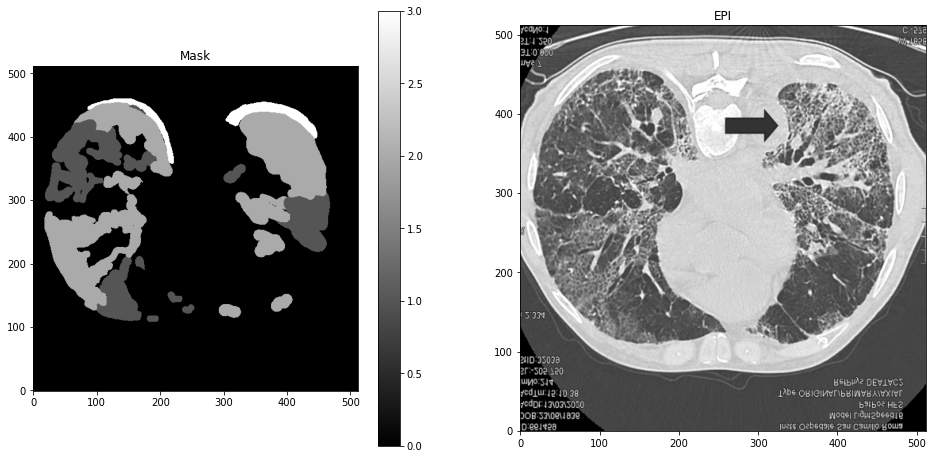

In [0]:
img_index = 1
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


img = ax1.imshow(mask_train[img_index,:,:,0], cmap="gray", origin="center")
ax1.set_title('Mask')
plt.colorbar(img, ax=ax1)

ax2.imshow(img_train[img_index,:,:,0], cmap="gray", origin="center")
ax2.set_title('EPI')

plt.show()

## 1.4) Generating the dataset for training the model

We will split our training data into a validation dataset to see if the model is good or overfitting.

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_train, mask_train, 
                                                    test_size=0.2, random_state=42)

print(f'The shape of our train dataset is: {X_train.shape}')
print(f'The shape of our validation dataset is: {X_test.shape}')

The shape of our train dataset is: (80, 512, 512, 1)
The shape of our validation dataset is: (20, 512, 512, 1)


## 2) Model

We will use a UNET with Xception backbone.

## 2.1) UNET

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def set_UNET(img_size, num_classes, momentum=0.9):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization(momentum=momentum)(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization(momentum=momentum)(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization(momentum=momentum)(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    previous_block_activation = x  # Set aside residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization(momentum=momentum)(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization(momentum=momentum)(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
img_size = img_train.shape[1:3]
num_classes = np.max(mask_train).astype('int') + 1

model = set_UNET(img_size, num_classes)
#model.summary()

## 2.2) Training

Let's compile our model

In [0]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0006), 
              loss="sparse_categorical_crossentropy")
              

Let's add some callbacks

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from IPython.display import clear_output

reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)

Model_Checkpoint = keras.callbacks.ModelCheckpoint("medseg_segmentation.h5", 
                                                  save_best_only=True)


class DisplayCallback(tf.keras.callbacks.Callback):
  
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    self._display(model.predict(img_train))
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))  

  def _display(self,im1):      
    fig = plt.figure(figsize=(12,6))
    gs = fig.add_gridspec(1, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    n_image = np.random.randint(0,len(val))
    mask = np.argmax(im1[n_image], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    ax1.imshow(mask[:,:, 0],cmap="gray", origin='center', animated=True)    
    plt.show()

callbacks= [reduce_LR, Model_Checkpoint, DisplayCallback()]

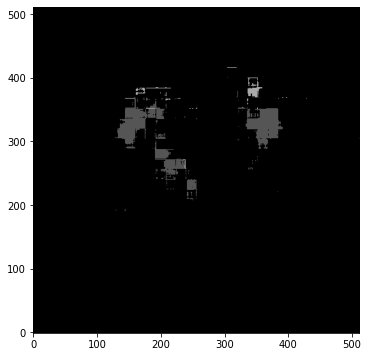


Sample Prediction after epoch 50

5/5 [==============================] - 6s 1s/step - loss: 0.1221 - val_loss: 0.1517 - lr: 6.0000e-10


In [120]:
EPOCHS = 50 #15
BATCH = 16

history = model.fit(X_train, y_train,
                    batch_size=BATCH,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

## 2.3) Metrics plot

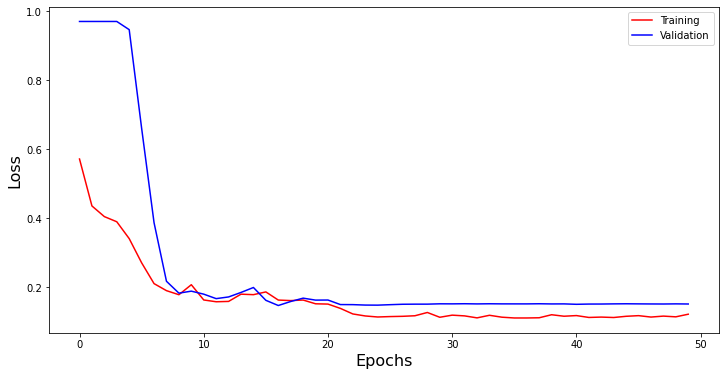

In [121]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])


ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

plt.show()

# 3) Predictions

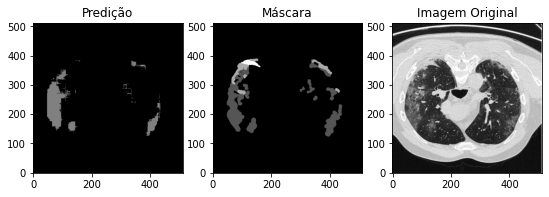

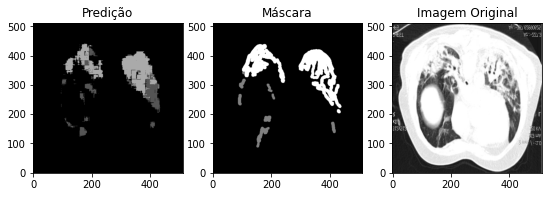

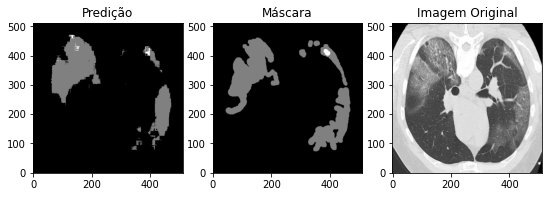

In [122]:
#plot dados 

val = model.predict(X_test)
n_to_show = 3

for i in range(n_to_show):
  n_image = np.random.randint(0,len(val))
  fig = plt.figure(figsize=(22,12))
  gs = fig.add_gridspec(1, 7)
  ax1 = fig.add_subplot(gs[0, 0])
  ax2 = fig.add_subplot(gs[0, 1])
  ax3 = fig.add_subplot(gs[0, 2])
  
  mask = np.argmax(val[n_image], axis=-1)
  mask = np.expand_dims(mask, axis=-1)

  ax1.imshow(mask[:,:, 0], cmap="gray", origin='center')
  ax1.set_title('Predição')
  ax2.imshow(y_test[n_image,:,:,0], cmap="gray", origin="center")
  ax2.set_title('Máscara')
  ax3.imshow(X_test[n_image,:,:,0], cmap="gray", origin="center")
  ax3.set_title('Imagem Original')
  plt.show()